# HBV hydrological model forced with ERA5 forcing data
In this notebook we will demonstrate how to generate forcing data for the HBV hydrological model from the ERA5 dataset using the eWaterCycle platform. It is assumed that you already have seen [this notebook which explains the basics of the HBV model and generating forcing using eWaterCycle](example_model_run_HBV_camels_catchment_camels_foring.ipynb). This notebooks purely focusses on the differences when generating forcing from ERA5.

Below a few collapsed cells are identical to those from that notebook.

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# region selected
caravan_id = "camelsgb_73010"

In [4]:
# time periods for experiment
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

# location of shape file
ERA5 is a global dataset. When creating forcing from ERA5 data, we need to provide a shape file that delineates the region of the world we want to create forcing for. Luckily the caravan dataset provides shapefiles for all catchments in the dataset. 

Here we re-load the forcing we generated in [this](example_model_run_HBV_camels_catchment_camels_foring.ipynb) notebook. The data we will use from this object is the shapefile (and later on, also the observations).

In [5]:
# location of caravan forcing
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / caravan_id / "caravan"

In [6]:
# load the caravan forcing object, just to get the shapefile
caravan_forcing_object = ewatercycle.forcing.sources['CaravanForcing'].load(directory=forcing_path_caravan)
print(caravan_forcing_object)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/forcing/camelsgb_73010/caravan'),
    shape=PosixPath('/home/rhut/forcing/camelsgb_73010/caravan/camelsgb_73010.shp'),
    filenames={
        'tasmin': 'camelsgb_73010_1997-08-01_2000-08-31_tasmin.nc',
        'tasmax': 'camelsgb_73010_1997-08-01_2000-08-31_tasmax.nc',
        'evspsblpot': 'camelsgb_73010_1997-08-01_2000-08-31_evspsblpot.nc',
        'pr': 'camelsgb_73010_1997-08-01_2000-08-31_pr.nc',
        'Q': 'camelsgb_73010_1997-08-01_2000-08-31_Q.nc',
        'tas': 'camelsgb_73010_1997-08-01_2000-08-31_tas.nc'
    }
)

In [7]:
# get the shapefile info
shapefile = caravan_forcing_object.shape
print(shapefile)

/home/rhut/forcing/camelsgb_73010/caravan/camelsgb_73010.shp

## Set up paths to store forcing data

Since forcing files are often re-used between experiments it is a best practice to save those intermediate files for re-use between experiments. These logical save-points in workflows are called 'rustpunten' in Dutch. It is important to store data in 'rustpunten' in standard formats. Working with clearly defined 'rustpunten' is a key element in the design of good workflows in general and was instrumental in designing eWaterCycle in particular. 

Here we set up some paths to store the forcing files we generate in your own home directory. 

In [8]:
# Location where the ERA5 forcing generated for your catchment of choice will be stored
forcing_path_ERA5 = Path.home() / "forcing" / caravan_id / "ERA5"
forcing_path_ERA5.mkdir(exist_ok=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_ERA5_central = Path("location/of/forcing/data")

## Generate or load forcing
when generating forcing using eWaterCycle there are two important choices to make: dataset that the data comes from and type of foring that the model requires. The dataset in this example is ERA5. The HBV model in eWaterCycle needs potential evaporation data. Both the 'caravan' type forcing as well as the 'LumpedMakkingForing' provide potential evaporation. Note that the 'caravan' type forcing only works with the 'caravan' dataset as well, so here we select 'ERA5 for the dataset and LumpedMakkingForing for the type.

Note that ERA5 data needs to be stored on the system you are working on. For SURF Research Cloud machines running the eWaterCycle catalog item, this is handled by the eWaterCycle team. 

More complex models often require their own type of forcing, for example the wflow model requires 'wflow' type forcing specifically designed for that model, but this is not the case for HBV in eWaterCycle.

In [9]:
# option one: generate forcing:
ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset="ERA5",
   start_time=experiment_start_date,
   end_time=experiment_end_date,
   directory=forcing_path_ERA5,
   shape=shapefile,
)

# # option two: load data that you or someone else generated previously
# #   this is needed because ERA5 forcing data is stored deep in a sub-directory
# load_location = prepared_forcing_path_ERA5_central / "work" / "diagnostic" / "script" 
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [10]:
print(ERA5_forcing_object)

LumpedMakkinkForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/forcing/camelsgb_73010/ERA5/work/diagnostic/script'),
    shape=PosixPath('/home/rhut/forcing/camelsgb_73010/caravan/camelsgb_73010.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_1997-2000.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_1997-2000.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1997-2000.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

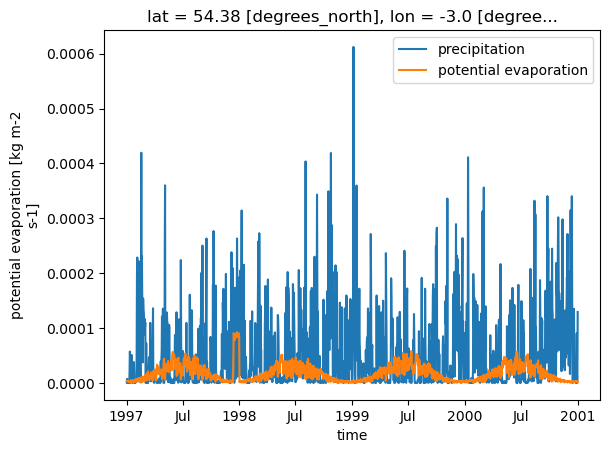

In [11]:
#quick plot of the precipitation and potential evaporation data
ds_ERA5 = xr.open_mfdataset([ERA5_forcing_object['pr'],ERA5_forcing_object['evspsblpot']])
ds_ERA5["pr"].plot(label = 'precipitation')
ds_ERA5["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()

## run model

from here on down everything is the same as in [this]() notebook that uses caravan foring, the only thing that changes is we now point to the ERA5 forcing object.

In [12]:
# load pre-calibrated parameters. 
# If you have calibrated for a different region, comment this part and 
# uncomment the load statement below
par_0 = [7.085, 0.837, 76.373, 1.112, 0.245, 7.801, 0.096, 0.003, 0.226];

# #load calibration constants from a csv file
# par_0 = np.loadtxt("your/calibration/file.csv", delimiter = ",")

In [13]:
#print parameter names and values
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(par_0, decimals=3))))

[
    ('Imax', 7.085),
    ('Ce', 0.837),
    ('Sumax', 76.373),
    ('Beta', 1.112),
    ('Pmax', 0.245),
    ('Tlag', 7.801),
    ('Kf', 0.096),
    ('Ks', 0.003),
    ('FM', 0.226)
]

In [14]:
# set inital state values
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [15]:
# create model object, notice the focing object.
model = ewatercycle.models.HBV(forcing=ERA5_forcing_object)

In [16]:
# create config file in model.setup()
config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)

In [17]:
# initialize model
model.initialize(config_file)

In [18]:
# run model, capture calculated discharge and timestamps 
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [19]:
#finalize model (shuts down container, frees memory)
model.finalize()

## Process results
Finally, we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [20]:
#make a pandas series
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

In [21]:
#load the observations from the caravan object
caravan_discharge_observation = xr.open_mfdataset([caravan_forcing_object['Q']])


Text(0, 0.5, 'Discharge (mm/d)')

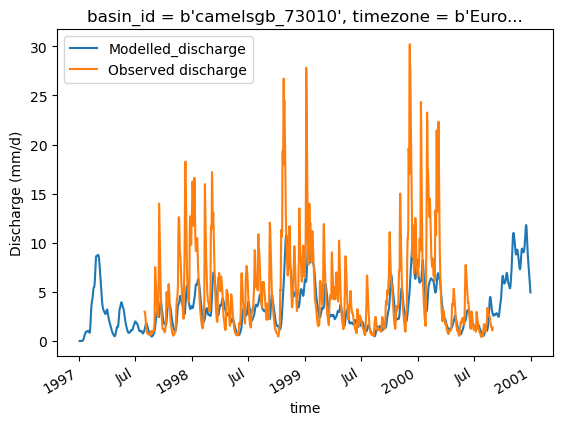

In [22]:
#make a plot of both the observations and modelled discharge
model_output.plot()
caravan_discharge_observation["Q"].plot(label="Observed discharge")
plt.legend()
plt.ylabel("Discharge (mm/d)")

In [23]:
#we want to also be able to use the output of this model run in different analyses. Therefore we save it as a NetCDF file
xr_model_output = model_output.to_xarray()

xr_model_output.attrs['units'] = 'mm/d'

# Save the xarray Dataset to a NetCDF file
xr_model_output.to_netcdf('~/river_discharge_data.nc')